In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr

import torch
import torch.nn as nn
import joblib

In [2]:
pot_id = "100pct_3day-removed"
pot_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{pot_id}_outputs"

x_id = "x-cond-3day"
x_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{x_id}_outputs"

y_id = "y-cond-3day"
y_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{y_id}_outputs"

In [3]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
model_pot = MLP(10)
model_pot.load_state_dict(torch.load(f'{pot_path}/model_{pot_id}.pt'))
model_pot.eval()

model_x = MLP(10)
model_x.load_state_dict(torch.load(f'{x_path}/model_{x_id}.pt'))
model_x.eval()

model_y = MLP(10)
model_y.load_state_dict(torch.load(f'{y_path}/model_{y_id}.pt'))
model_y.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [5]:
#Load omni data
omni_data = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_5min_1999-10.csv')
#omni_data = omni_data[omni_data['Timestamp_1min_omni'] == '1999-10-01 00:00:00']
omni_data = omni_data[omni_data['Timestamp_1min_omni'].between('1999-10-01 00:00:00', '1999-10-01 23:59:59')]
omni_data

,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,Timestamp_1min_omni,Timestamp_1hr_omni,F10.7,Kp,tilt_angle
0,1.84,0.66,485.000000,4.17,178,-100,79,1999-10-01 00:00:00,1999-10-01 00:00:00,121.900002,23,-0.115365
1,3.35,0.41,481.899994,4.51,178,-107,71,1999-10-01 00:05:00,1999-10-01 00:00:00,121.900002,23,-0.119096
2,3.26,0.45,480.899994,4.63,178,-100,78,1999-10-01 00:10:00,1999-10-01 00:00:00,121.900002,23,-0.122795
3,2.70,-1.26,480.000000,4.81,169,-89,80,1999-10-01 00:15:00,1999-10-01 00:00:00,121.900002,23,-0.126461
4,2.21,-1.06,475.100006,4.71,227,-151,76,1999-10-01 00:20:00,1999-10-01 00:00:00,121.900002,23,-0.130093
...,...,...,...,...,...,...,...,...,...,...,...,...
283,4.12,-1.18,435.399994,6.07,213,-138,75,1999-10-01 23:35:00,1999-10-01 23:00:00,121.900002,13,-0.103219
284,4.59,-1.28,441.600006,5.71,192,-121,70,1999-10-01 23:40:00,1999-10-01 23:00:00,121.900002,13,-0.107079
285,4.91,-0.91,439.899994,6.12,152,-97,55,1999-10-01 23:45:00,1999-10-01 23:00:00,121.900002,13,-0.110916
286,4.95,-0.75,439.200012,6.00,189,-112,78,1999-10-01 23:50:00,1999-10-01 23:00:00,121.900002,13,-0.114730


In [6]:
def split_to_df(df):

    df = df.copy()

    #filters
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10

    #change data types
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)

    #create grid of lat and lon
    lat = np.linspace(50, 90, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(1, 360, 80) #80 intervals between 1.6° to 357.6°

    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lats = lat_mesh.flatten()
    lons = lon_mesh.flatten()

    #expand out df to lat and lon dims. Aka repeat values 
    expanded_df = pd.DataFrame({'lat': lats.repeat(len(df)), 
                                'lon': lons.repeat(len(df)),
                                'BY_GSE': np.tile(df['BY_GSE'], len(lat)*len(lon)),
                                'BZ_GSE': np.tile(df['BZ_GSE'], len(lat)*len(lon)),
                                'flow_speed': np.tile(df['flow_speed'], len(lat)*len(lon)),
                                'proton_density': np.tile(df['proton_density'], len(lat)*len(lon)),
                                'tilt_angle': np.tile(df['tilt_angle'], len(lat)*len(lon)),
                                'dt': np.tile(df['Timestamp_1min_omni'], len(lat)*len(lon)),
                                'F10.7': np.tile(df['F10.7'], len(lat)*len(lon)),
                                'Kp': np.tile(df['Kp'], len(lat)*len(lon)),
                                'AE_INDEX': np.tile(df['AE_INDEX'], len(lat)*len(lon)),
                                'AL_INDEX': np.tile(df['AL_INDEX'], len(lat)*len(lon)),
                                'AU_INDEX': np.tile(df['AU_INDEX'], len(lat)*len(lon))})

    expanded_df['mlt'] = np.mod(expanded_df['lon'] + 12, 360) / 15


    df_2 = expanded_df.copy()
    df_2 = df_2[['dt','mlt','lon','lat','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]

    df_2['mlt_sin'] = np.sin(df_2['mlt']*(2.*np.pi/24))
    df_2['mlt_cos'] = np.cos(df_2['mlt']*(2.*np.pi/24))

    df_2['lon_sin'] = np.sin((df_2['lon']-1)*(2.*np.pi/360))
    df_2['lon_cos'] = np.cos((df_2['lon']-1)*(2.*np.pi/360))

    df_2 = df_2.drop(columns=['dt'])

    return expanded_df, df_2

df_raw, df_proc = split_to_df(omni_data)
df_raw


,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt
0,50.0,1.0,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.866667
1,50.0,1.0,3.35,0.41,481,4.51,-0.119096,1999-10-01 00:05:00,121,2.3,178,-107,71,0.866667
2,50.0,1.0,3.26,0.45,480,4.63,-0.122795,1999-10-01 00:10:00,121,2.3,178,-100,78,0.866667
3,50.0,1.0,2.70,-1.26,480,4.81,-0.126461,1999-10-01 00:15:00,121,2.3,169,-89,80,0.866667
4,50.0,1.0,2.21,-1.06,475,4.71,-0.130093,1999-10-01 00:20:00,121,2.3,227,-151,76,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681595,90.0,360.0,4.12,-1.18,435,6.07,-0.103219,1999-10-01 23:35:00,121,1.3,213,-138,75,0.800000
681596,90.0,360.0,4.59,-1.28,441,5.71,-0.107079,1999-10-01 23:40:00,121,1.3,192,-121,70,0.800000
681597,90.0,360.0,4.91,-0.91,439,6.12,-0.110916,1999-10-01 23:45:00,121,1.3,152,-97,55,0.800000
681598,90.0,360.0,4.95,-0.75,439,6.00,-0.114730,1999-10-01 23:50:00,121,1.3,189,-112,78,0.800000


In [172]:
'''
with open(f'{pot_path}/scaler_{pot_id}.pkl', 'rb') as f:
    scaler = pickle.load(f)

col_names = df_proc.columns
norm_arr = scaler.transform(df_proc)
df_proc = pd.DataFrame(norm_arr, columns=col_names)
df_proc = df_proc.drop(columns=['mlt','lon'])
df_proc'''

"\nwith open(f'{pot_path}/scaler_{pot_id}.pkl', 'rb') as f:\n    scaler = pickle.load(f)\n\ncol_names = df_proc.columns\nnorm_arr = scaler.transform(df_proc)\ndf_proc = pd.DataFrame(norm_arr, columns=col_names)\ndf_proc = df_proc.drop(columns=['mlt','lon'])\ndf_proc"

In [7]:
def rescale(df, path, id):

    df = df.copy()
    
    with open(f'{path}/scaler_{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    col_names = df.columns
    norm_arr = scaler.transform(df)
    df = pd.DataFrame(norm_arr, columns=col_names)
    df = df.drop(columns=['mlt','lon'])
    
    return df

df_pot = rescale(df_proc, pot_path, pot_id)
df_x = rescale(df_proc, x_path, x_id)
df_y = rescale(df_proc, y_path, y_id)

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [51]:
def make_predictions(df, model):

    df = df.copy()

    df = df.to_numpy()
    
    df = torch.tensor(df, dtype=torch.float32)

    batch_size = 10000  # Adjust this value based on your system's memory capacity
    n = len(df)
    predictions = []

    for i in range(0, n, batch_size):
        batch = df[i:i+batch_size]
        batch_pred = model(batch).detach().cpu().numpy()
        batch_pred = batch_pred.flatten()
        predictions.extend(batch_pred)

    return predictions

pot_pred = make_predictions(df_pot, model_pot)
x_pred = make_predictions(df_x, model_x)
y_pred = make_predictions(df_y, model_y)

df_comp = df_raw
df_comp['pot_pred'] = pot_pred
df_comp['x_pred'] = x_pred
df_comp['y_pred'] = y_pred

In [10]:
'''
df_proc = df_proc.to_numpy()
df_proc = torch.tensor(df_proc, dtype=torch.float32)

batch_size = 10000  # Adjust this value based on your system's memory capacity
n = len(df_proc)
predictions = []

for i in range(0, n, batch_size):
    batch = df_proc[i:i+batch_size]
    batch_pred = model_pot(batch).detach().cpu().numpy()
    batch_pred = batch_pred.flatten()
    predictions.extend(batch_pred)

df_raw['potential_pred'] = predictions
df_comp = df_raw
df_comp'''

"\ndf_proc = df_proc.to_numpy()\ndf_proc = torch.tensor(df_proc, dtype=torch.float32)\n\nbatch_size = 10000  # Adjust this value based on your system's memory capacity\nn = len(df_proc)\npredictions = []\n\nfor i in range(0, n, batch_size):\n    batch = df_proc[i:i+batch_size]\n    batch_pred = model_pot(batch).detach().cpu().numpy()\n    batch_pred = batch_pred.flatten()\n    predictions.extend(batch_pred)\n\ndf_raw['potential_pred'] = predictions\ndf_comp = df_raw\ndf_comp"

In [52]:
def filter_by_dt(df):
   df = df.copy()
   #df = df[df['dt']=='1999-10-01 12:00:00']

   return df

df_filt = filter_by_dt(df_comp)
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt,pot_pred,x_pred,y_pred
0,50.0,1.0,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.866667,3.645132,1.840221,1.623086
1,50.0,1.0,3.35,0.41,481,4.51,-0.119096,1999-10-01 00:05:00,121,2.3,178,-107,71,0.866667,2.387830,1.838853,1.624136
2,50.0,1.0,3.26,0.45,480,4.63,-0.122795,1999-10-01 00:10:00,121,2.3,178,-100,78,0.866667,2.429732,1.841599,1.623088
3,50.0,1.0,2.70,-1.26,480,4.81,-0.126461,1999-10-01 00:15:00,121,2.3,169,-89,80,0.866667,2.581500,1.833280,1.624136
4,50.0,1.0,2.21,-1.06,475,4.71,-0.130093,1999-10-01 00:20:00,121,2.3,227,-151,76,0.866667,1.542206,1.842467,1.623084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681595,90.0,360.0,4.12,-1.18,435,6.07,-0.103219,1999-10-01 23:35:00,121,1.3,213,-138,75,0.800000,14.693553,1.617309,1.629327
681596,90.0,360.0,4.59,-1.28,441,5.71,-0.107079,1999-10-01 23:40:00,121,1.3,192,-121,70,0.800000,-3.172566,1.638096,1.628504
681597,90.0,360.0,4.91,-0.91,439,6.12,-0.110916,1999-10-01 23:45:00,121,1.3,152,-97,55,0.800000,1.290583,1.638310,1.626204
681598,90.0,360.0,4.95,-0.75,439,6.00,-0.114730,1999-10-01 23:50:00,121,1.3,189,-112,78,0.800000,4.310442,1.619311,1.625231


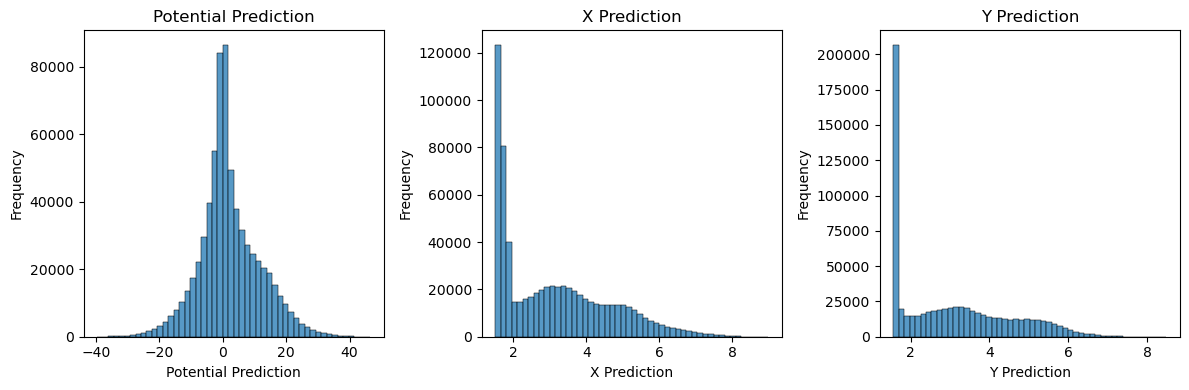

In [53]:
#plot pot_pred, x_pred, y_pred 
figs, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(df_filt['pot_pred'], ax=axs[0], bins=50)
axs[0].set_title('Potential Prediction')
axs[0].set_xlabel('Potential Prediction')
axs[0].set_ylabel('Frequency')

sns.histplot(df_filt['x_pred'], ax=axs[1], bins=50)
axs[1].set_title('X Prediction')
axs[1].set_xlabel('X Prediction')
axs[1].set_ylabel('Frequency')

sns.histplot(df_filt['y_pred'], ax=axs[2], bins=50)
axs[2].set_title('Y Prediction')
axs[2].set_xlabel('Y Prediction')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

In [54]:
lon_d = 360 / 80 
lat_d = 40 / 30

In [55]:
#lon_d = 360 / 80 
#lat_d = 90 / 30

#dx, dy = 1.37, 1
dx, dy, = 1.33, 4.5 #90-50 = 40/30 = 1.33, 360/80 = 4.5
#grad x is north-south, grad y is east-west

#loop through dt
for dt in df_filt['dt'].unique():
    df_dt = df_filt[df_filt['dt'] == dt]
    grad_x, grad_y = np.gradient(df_dt['pot_pred'].values.reshape(30,80), dx, dy)
    grad_x = grad_x.flatten()
    grad_y = grad_y.flatten()
    Ex = -grad_x
    Ey = -grad_y

    df_filt.loc[df_filt['dt'] == dt, 'Ex'] = Ex
    df_filt.loc[df_filt['dt'] == dt, 'Ey'] = Ey

df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt,pot_pred,x_pred,y_pred,Ex,Ey
0,50.0,1.0,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.866667,3.645132,1.840221,1.623086,-0.691008,-0.126329
1,50.0,1.0,3.35,0.41,481,4.51,-0.119096,1999-10-01 00:05:00,121,2.3,178,-107,71,0.866667,2.387830,1.838853,1.624136,-2.553121,-0.018479
2,50.0,1.0,3.26,0.45,480,4.63,-0.122795,1999-10-01 00:10:00,121,2.3,178,-100,78,0.866667,2.429732,1.841599,1.623088,-4.683886,-0.113727
3,50.0,1.0,2.70,-1.26,480,4.81,-0.126461,1999-10-01 00:15:00,121,2.3,169,-89,80,0.866667,2.581500,1.833280,1.624136,-1.514082,0.016983
4,50.0,1.0,2.21,-1.06,475,4.71,-0.130093,1999-10-01 00:20:00,121,2.3,227,-151,76,0.866667,1.542206,1.842467,1.623084,-1.833315,0.082471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681595,90.0,360.0,4.12,-1.18,435,6.07,-0.103219,1999-10-01 23:35:00,121,1.3,213,-138,75,0.800000,14.693553,1.617309,1.629327,-11.421906,0.038116
681596,90.0,360.0,4.59,-1.28,441,5.71,-0.107079,1999-10-01 23:40:00,121,1.3,192,-121,70,0.800000,-3.172566,1.638096,1.628504,1.557960,-0.234031
681597,90.0,360.0,4.91,-0.91,439,6.12,-0.110916,1999-10-01 23:45:00,121,1.3,152,-97,55,0.800000,1.290583,1.638310,1.626204,-4.948089,-0.231561
681598,90.0,360.0,4.95,-0.75,439,6.00,-0.114730,1999-10-01 23:50:00,121,1.3,189,-112,78,0.800000,4.310442,1.619311,1.625231,-6.962617,0.083030


In [57]:
df_filt.sort_values(by=['dt','lat','lon'], inplace=False)

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt,pot_pred,x_pred,y_pred,Ex,Ey
0,50.0,1.000000,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.866667,3.645132,1.840221,1.623086,-0.691008,-0.126329
8520,50.0,5.544304,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,1.169620,2.675131,1.859772,1.623087,-2.303215,2.394248
17040,50.0,10.088608,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,1.472574,3.139097,1.857935,1.623081,-1.348810,2.849913
25560,50.0,14.632911,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,1.775527,2.576223,1.860741,1.623073,-4.328091,2.931673
34080,50.0,19.177215,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,2.078481,1.505834,1.859895,1.623075,-3.942725,2.696511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647519,90.0,341.822785,4.80,-1.68,441,6.33,-0.118517,1999-10-01 23:55:00,121,1.3,195,-119,76,23.588186,-8.261148,1.647918,1.639867,2.595361,-1.182013
656039,90.0,346.367089,4.80,-1.68,441,6.33,-0.118517,1999-10-01 23:55:00,121,1.3,195,-119,76,23.891139,-5.314202,1.628213,1.642741,2.920431,-1.065297
664559,90.0,350.911392,4.80,-1.68,441,6.33,-0.118517,1999-10-01 23:55:00,121,1.3,195,-119,76,0.194093,-11.792112,1.618762,1.635439,6.664190,-1.222352
673079,90.0,355.455696,4.80,-1.68,441,6.33,-0.118517,1999-10-01 23:55:00,121,1.3,195,-119,76,0.497046,-7.740649,1.618685,1.638453,2.413432,-0.996209


In [58]:

#Ex = -grad_x
#Ey = -grad_y

#df_filt['Ex'] = Ex.flatten() #north-south
#df_filt['Ey'] = Ey.flatten()  #east-west

#calculate conductivity tensor
df_filt['sigma_xy'] = df_filt['x_pred'] * df_filt['y_pred']
df_filt['sigma_xx'] = df_filt['x_pred']**2
df_filt['sigma_yy'] = df_filt['y_pred']**2
df_filt['sigma_neg_xy'] = -df_filt['x_pred'] * df_filt['y_pred']

#calculate Hall and Pedersen currents
df_filt['JHx'] = df_filt['sigma_xy'] * df_filt['Ey'] #east-west
df_filt['JHy'] = df_filt['sigma_neg_xy'] * df_filt['Ex'] #north-south
df_filt['JPx'] = df_filt['sigma_xx'] * df_filt['Ex']
df_filt['JPy'] = df_filt['sigma_yy'] * df_filt['Ey']
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,...,Ex,Ey,sigma_xy,sigma_xx,sigma_yy,sigma_neg_xy,JHx,JHy,JPx,JPy
0,50.0,1.0,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,-0.691008,-0.126329,2.986838,3.386415,2.634408,-2.986838,-0.377323,2.063930,-2.340041,-0.332801
1,50.0,1.0,3.35,0.41,481,4.51,-0.119096,1999-10-01 00:05:00,121,2.3,...,-2.553121,-0.018479,2.986548,3.381381,2.637818,-2.986548,-0.055187,7.625017,-8.633073,-0.048743
2,50.0,1.0,3.26,0.45,480,4.63,-0.122795,1999-10-01 00:10:00,121,2.3,...,-4.683886,-0.113727,2.989077,3.391487,2.634413,-2.989077,-0.339939,14.000494,-15.885338,-0.299604
3,50.0,1.0,2.70,-1.26,480,4.81,-0.126461,1999-10-01 00:15:00,121,2.3,...,-1.514082,0.016983,2.977497,3.360917,2.637818,-2.977497,0.050567,4.508175,-5.088705,0.044798
4,50.0,1.0,2.21,-1.06,475,4.71,-0.130093,1999-10-01 00:20:00,121,2.3,...,-1.833315,0.082471,2.990478,3.394683,2.634402,-2.990478,0.246629,5.482489,-6.223524,0.217263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681595,90.0,360.0,4.12,-1.18,435,6.07,-0.103219,1999-10-01 23:35:00,121,1.3,...,-11.421906,0.038116,2.635124,2.615687,2.654706,-2.635124,0.100441,30.098139,-29.876131,0.101187
681596,90.0,360.0,4.59,-1.28,441,5.71,-0.107079,1999-10-01 23:40:00,121,1.3,...,1.557960,-0.234031,2.667646,2.683358,2.652027,-2.667646,-0.624311,-4.156087,4.180565,-0.620655
681597,90.0,360.0,4.91,-0.91,439,6.12,-0.110916,1999-10-01 23:45:00,121,1.3,...,-4.948089,-0.231561,2.664227,2.684061,2.644540,-2.664227,-0.616931,13.182833,-13.280970,-0.612372
681598,90.0,360.0,4.95,-0.75,439,6.00,-0.114730,1999-10-01 23:50:00,121,1.3,...,-6.962617,0.083030,2.631754,2.622168,2.641374,-2.631754,0.218516,18.323896,-18.257154,0.219315


In [59]:
df_filt = df_filt.sample(frac=0.01)
df_filt['dt'] = pd.to_datetime(df_filt['dt'])
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,...,Ex,Ey,sigma_xy,sigma_xx,sigma_yy,sigma_neg_xy,JHx,JHy,JPx,JPy
199919,67.931034,105.518987,3.30,0.49,444,5.43,-0.055810,1999-10-01 22:35:00,121,1.3,...,-0.163250,0.272262,16.834196,17.853937,15.872699,-16.834196,4.583315,2.748183,-2.914656,4.321536
421667,69.310345,223.670886,4.64,1.18,453,4.86,0.115776,1999-10-01 17:55:00,121,1.7,...,4.528910,-0.573089,31.273027,27.930820,35.015163,-31.273027,-17.922239,-141.632721,126.496162,-20.066818
550273,73.448276,291.835443,3.69,-0.77,467,4.16,0.089420,1999-10-01 14:05:00,121,3.0,...,-1.750266,0.155850,6.678174,6.502506,6.858589,-6.678174,1.040791,11.688580,-11.381113,1.068909
397128,74.827586,210.037975,-1.83,0.27,464,4.54,-0.154660,1999-10-01 08:20:00,121,1.3,...,-7.340281,0.031539,7.407986,5.840233,9.396587,-7.407986,0.233642,54.376698,-42.868950,0.296361
637125,81.724138,337.278481,0.00,-0.01,463,4.31,-0.093155,1999-10-01 09:45:00,121,1.7,...,5.698210,0.390344,2.620258,2.607871,2.632704,-2.620258,1.022803,-14.930781,14.860195,1.027661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673187,50.000000,360.000000,3.60,-0.25,477,3.85,-0.115898,1999-10-01 09:15:00,121,1.7,...,-2.451010,0.326862,2.999726,3.415709,2.634403,-2.999726,0.980497,7.352356,-8.371935,0.861087
228159,81.724138,119.151899,3.60,-0.25,477,3.85,-0.115898,1999-10-01 09:15:00,121,1.7,...,1.535750,-0.127717,2.746078,2.863172,2.633772,-2.746078,-0.350720,-4.217289,4.397117,-0.336377
326925,65.172414,173.683544,1.82,-1.94,459,3.73,-0.230235,1999-10-01 03:45:00,121,2.7,...,5.135400,-0.042451,10.076535,11.656044,8.711064,-10.076535,-0.427763,-51.747044,59.858452,-0.369797
594668,81.724138,314.556962,1.00,-0.65,429,4.81,-0.012426,1999-10-01 21:40:00,121,1.3,...,-0.985556,-0.025040,2.630861,2.631959,2.629764,-2.630861,-0.065875,2.592861,-2.593942,-0.065848


In [60]:
df_filt['P'] = np.sqrt(df_filt['JHx']**2 + df_filt['JHy']**2)

In [61]:
df_filt.describe().T

,count,mean,min,25%,50%,75%,max,std
lat,6816.0,69.936053,50.0,59.655172,69.310345,80.344828,90.0,11.942518
lon,6816.0,179.477932,1.0,87.341772,178.227848,273.658228,360.0,105.475945
BY_GSE,6816.0,2.40369,-3.19,1.54,2.66,3.47,5.05,1.52231
BZ_GSE,6816.0,0.270461,-3.31,-0.72,0.24,1.26,3.36,1.400636
flow_speed,6816.0,461.273034,422.0,451.0,461.0,471.0,499.0,14.692619
proton_density,6816.0,4.37374,2.78,3.92,4.31,4.84,6.33,0.649489
tilt_angle,6816.0,-0.054509,-0.235091,-0.179396,-0.054916,0.070954,0.126912,0.126732
dt,6816,1999-10-01 11:57:55.748239360,1999-10-01 00:00:00,1999-10-01 06:10:00,1999-10-01 11:50:00,1999-10-01 18:00:00,1999-10-01 23:55:00,NaN
F10.7,6816.0,121.0,121.0,121.0,121.0,121.0,121.0,0.0
Kp,6816.0,2.125132,1.3,1.3,1.7,3.0,3.0,0.678253


-0.0008348768521600617

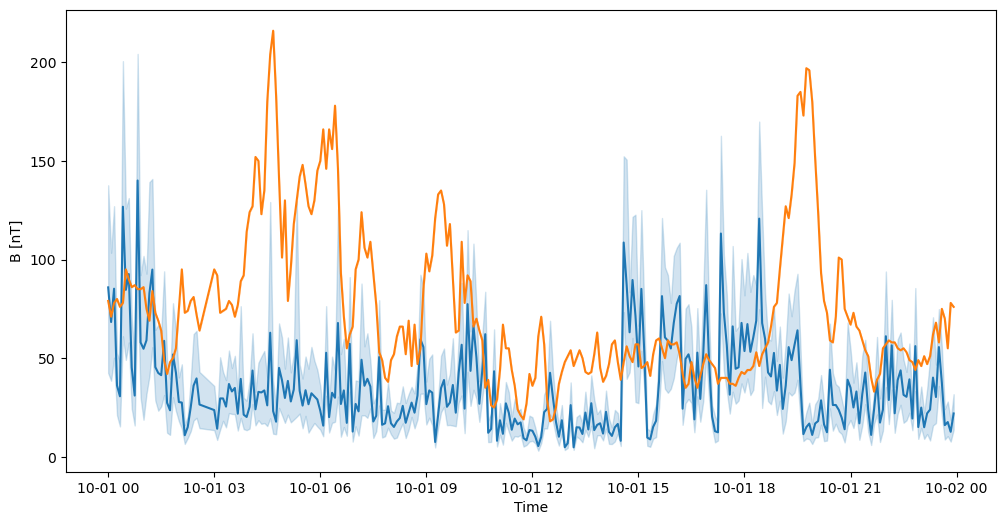

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_filt, x='dt', y='P', ax=ax)
sns.lineplot(data=df_filt, x='dt', y='AU_INDEX', ax=ax)
plt.xlabel('Time')
plt.ylabel('B [nT]')

R = df_filt['P'].corr(df_filt['AU_INDEX'])
R

In [13]:
'''
sigma_xy = np.zeros((30,80))
J_x = np.zeros((30,80))
J_y = np.zeros((30,80))

x_sigma = np.array(x_pred).reshape(30,80)
y_sigma = np.array(y_pred).reshape(30,80)


for i in range(30):
    for j in range(80):
        sigma_xy[i,j] = x_sigma[i,j] * y_sigma[i,j] 

        J_x[i,j] = sigma_xy[i,j] * Ey[i,j]
        J_y[i,j] = -sigma_xy[i,j] * Ex[i,j]

df_filt['sigma_xy'] = sigma_xy.flatten()
df_filt['J_x'] = J_x.flatten()
df_filt['J_y'] = J_y.flatten()
df_filt'''

"\nsigma_xy = np.zeros((30,80))\nJ_x = np.zeros((30,80))\nJ_y = np.zeros((30,80))\n\nx_sigma = np.array(x_pred).reshape(30,80)\ny_sigma = np.array(y_pred).reshape(30,80)\n\n\nfor i in range(30):\n    for j in range(80):\n        sigma_xy[i,j] = x_sigma[i,j] * y_sigma[i,j] \n\n        J_x[i,j] = sigma_xy[i,j] * Ey[i,j]\n        J_y[i,j] = -sigma_xy[i,j] * Ex[i,j]\n\ndf_filt['sigma_xy'] = sigma_xy.flatten()\ndf_filt['J_x'] = J_x.flatten()\ndf_filt['J_y'] = J_y.flatten()\ndf_filt"

ValueError: 'x' must be strictly increasing

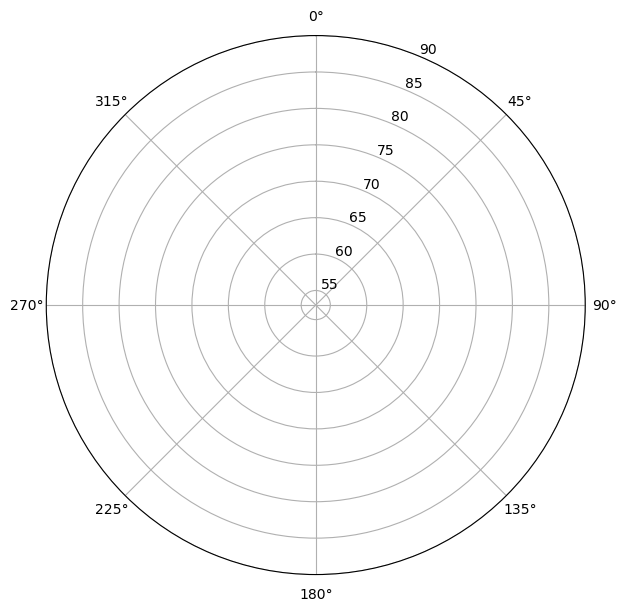

In [138]:
#quiver plot on polar projection
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(53, 90)

#plot quiver
ax.streamplot(df_filt['lon'], df_filt['lat'], df_filt['JPx'], df_filt['JPy'], color='r')


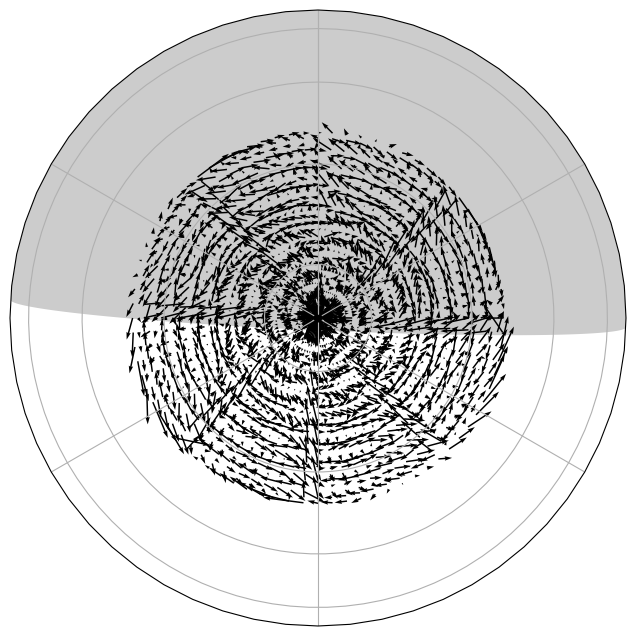

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

def sample_data(shape=(30, 80)):
    """
    Returns ``(x, y, u, v, crs)`` of some vector data
    computed mathematically. The returned crs will be a PlateCarree CRS.

    """
    crs = ccrs.RotatedPole(pole_longitude=0, pole_latitude=90)

    lat = np.linspace(53, 90, shape[0])
    lon = np.linspace(0, 360, shape[1], endpoint=False)


    return lon, lat, crs

def main():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

    #ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    #ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

    ax.set_global()
    ax.gridlines()
    #ax.coastlines()
    #ax.set_extent([-180, 180, 53, 90], ccrs.PlateCarree())

    lon, lat, vector_crs = sample_data()
    ax.quiver(lon, lat, Ex, Ey, transform=vector_crs, scale=400)

    date = datetime.datetime(1999, 10, 1, 12)
    ax.add_feature(Nightshade(date, alpha=0.2))

    plt.show()

if __name__ == '__main__':
    main()
